<a href="https://colab.research.google.com/github/darbyna/DATA606_Capstone/blob/main/Cleaned_Data_and_EDA_%7C_DATA606_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#An Investigation of Particulate Matter 2.5 in the DC area during the COVID-19 Pandemic

### Capstone Project for Data 606

#### Description:


In [ ]:
#Import and install necessary packages:
import os 
import glob
import scipy
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.regression import LinearRegression
import requests
from sklearn import metrics
from sklearn.metrics import accuracy_score
from bs4 import BeautifulSoup


# Import Particulate Matter 2.5 Data: 

In [ ]:

PM25_2015 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2015_data_DC_pm25.csv',
   )
PM25_2016 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2016_data_DC_pm25.csv',
   )
PM25_2017 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2017_data_DC_pm25.csv',
   )
PM25_2018 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2018_data_DC_pm25.csv',
   )
PM25_2019 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2019_data_DC_pm25.csv',
   )
PM25_2020 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2020_data_DC_pm25.csv',
   )
DC_PM25_Concentrations = PM25_2015.append(PM25_2016).append(PM25_2017).append(PM25_2018).append(PM25_2019).append(PM25_2020)
DC_PM25_Concentrations = DC_PM25_Concentrations.dropna()
DC_PM25_Concentrations = DC_PM25_Concentrations.rename(columns={"Daily Mean PM2.5 Concentration":"Daily_Mean_PM25_Concentration"})
DC_PM25_Concentrations


,Date,Source,Site ID,POC,Daily_Mean_PM25_Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/03/2015,AQS,110010042,1,18.0,ug/m3 LC,63,HAINS POINT PM-2.5 AND IMPROVE SITE ON ROOF OF...,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.876255,-77.034059
1,01/06/2015,AQS,110010042,1,8.9,ug/m3 LC,37,HAINS POINT PM-2.5 AND IMPROVE SITE ON ROOF OF...,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.876255,-77.034059
2,01/09/2015,AQS,110010042,1,6.6,ug/m3 LC,28,HAINS POINT PM-2.5 AND IMPROVE SITE ON ROOF OF...,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.876255,-77.034059
3,01/12/2015,AQS,110010042,1,12.0,ug/m3 LC,50,HAINS POINT PM-2.5 AND IMPROVE SITE ON ROOF OF...,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.876255,-77.034059
4,01/15/2015,AQS,110010042,1,21.6,ug/m3 LC,71,HAINS POINT PM-2.5 AND IMPROVE SITE ON ROOF OF...,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.876255,-77.034059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,12/27/2020,AQS,110010053,1,8.2,ug/m3 LC,34,King Greenleaf Rec Center,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.875161,-77.012816
1901,12/28/2020,AQS,110010053,1,7.8,ug/m3 LC,33,King Greenleaf Rec Center,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.875161,-77.012816
1902,12/29/2020,AQS,110010053,1,4.7,ug/m3 LC,20,King Greenleaf Rec Center,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.875161,-77.012816
1903,12/30/2020,AQS,110010053,1,6.2,ug/m3 LC,26,King Greenleaf Rec Center,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.875161,-77.012816


# Import Particulate Matter 10 Data:

In [ ]:
PM10_2015 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2015_data_DC_pm10.csv',
   )
PM10_2016 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2016_data_DC_pm10.csv',
   )
PM10_2017 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2017_data_DC_pm10.csv',
   )
PM10_2018 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2018_data_DC_pm10.csv',
   )
PM10_2019 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2019_data_DC_pm10.csv',
   )
PM10_2020 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2020_data_DC_pm10.csv',
   )
DC_PM10_Concentrations = PM10_2015.append(PM10_2016).append(PM10_2017).append(PM10_2018).append(PM10_2019).append(PM10_2020)
DC_PM10_Concentrations

,Date,Source,Site ID,POC,Daily Mean PM10 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/01/2015,AQS,110010043,4,12,ug/m3 SC,11,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
1,01/02/2015,AQS,110010043,4,16,ug/m3 SC,15,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
2,01/03/2015,AQS,110010043,4,22,ug/m3 SC,20,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
3,01/04/2015,AQS,110010043,4,5,ug/m3 SC,5,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
4,01/05/2015,AQS,110010043,4,7,ug/m3 SC,6,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,12/27/2020,AQS,110010043,4,16,ug/m3 SC,15,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
336,12/28/2020,AQS,110010043,4,19,ug/m3 SC,18,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
337,12/29/2020,AQS,110010043,4,10,ug/m3 SC,9,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
338,12/30/2020,AQS,110010043,4,14,ug/m3 SC,13,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178


# Import Sulphur Dioxide (SO2) Data:

In [ ]:
SO2_2015 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2015_data_DC_so2.csv',
   )
SO2_2016 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2016_data_DC_so2.csv',
   )
SO2_2017 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2017_data_DC_so2.csv',
   )
SO2_2018 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2018_data_DC_so2.csv',
   )
SO2_2019 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2019_data_DC_so2.csv',
   )
SO2_2020 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2020_data_DC_so2.csv',
   )
DC_SO2_Concentrations = SO2_2015.append(SO2_2016).append(SO2_2017).append(SO2_2018).append(SO2_2019).append(SO2_2020)
DC_SO2_Concentrations

,Date,Source,Site ID,POC,Daily Max 1-hour SO2 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/01/2015,AQS,110010043,2,2.6,ppb,3,MCMILLAN NCore-PAMS,24,100.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
1,01/02/2015,AQS,110010043,2,4.7,ppb,6,MCMILLAN NCore-PAMS,24,100.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
2,01/03/2015,AQS,110010043,2,4.5,ppb,6,MCMILLAN NCore-PAMS,24,100.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
3,01/04/2015,AQS,110010043,2,1.3,ppb,1,MCMILLAN NCore-PAMS,24,100.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
4,01/05/2015,AQS,110010043,2,6.1,ppb,9,MCMILLAN NCore-PAMS,23,96.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,12/27/2020,AQS,110010043,2,1.2,ppb,1,MCMILLAN NCore-PAMS,24,100.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
360,12/28/2020,AQS,110010043,2,1.3,ppb,1,MCMILLAN NCore-PAMS,24,100.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
361,12/29/2020,AQS,110010043,2,1.6,ppb,1,MCMILLAN NCore-PAMS,22,92.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
362,12/30/2020,AQS,110010043,2,2.2,ppb,3,MCMILLAN NCore-PAMS,24,100.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178


# Import Nitrogen Dioxide (NO2) Data:

In [ ]:
NO2_2015 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2015_data_DC_no2.csv',
   )
NO2_2016 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2016_data_DC_no2.csv',
   )
NO2_2017 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2017_data_DC_no2.csv',
   )
NO2_2018 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2018_data_DC_no2.csv',
   )
NO2_2019 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2019_data_DC_no2.csv',
   )
NO2_2020 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2020_data_DC_no2.csv',
   )
DC_NO2_Concentrations = NO2_2015.append(NO2_2016).append(NO2_2017).append(NO2_2018).append(NO2_2019).append(NO2_2020)
DC_NO2_Concentrations

,Date,Source,Site ID,POC,Daily Max 1-hour NO2 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/01/2015,AQS,110010043,1,38.7,ppb,36,MCMILLAN NCore-PAMS,24,100.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
1,01/02/2015,AQS,110010043,1,42.3,ppb,40,MCMILLAN NCore-PAMS,24,100.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
2,01/03/2015,AQS,110010043,1,44.2,ppb,42,MCMILLAN NCore-PAMS,24,100.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
3,01/04/2015,AQS,110010043,1,25.0,ppb,24,MCMILLAN NCore-PAMS,24,100.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
4,01/05/2015,AQS,110010043,1,9.5,ppb,8,MCMILLAN NCore-PAMS,24,100.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,12/27/2020,AQS,110010051,1,29.5,ppb,27,Near Road,20,83.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426
1701,12/28/2020,AQS,110010051,1,31.5,ppb,29,Near Road,24,100.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426
1702,12/29/2020,AQS,110010051,1,36.5,ppb,34,Near Road,24,100.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426
1703,12/30/2020,AQS,110010051,1,34.3,ppb,32,Near Road,22,92.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426


# Import Carbon Monoxide (CO) Data:


In [ ]:
CO_2015 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2015_data_DC_co.csv',
   )
CO_2016 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2016_data_DC_co.csv',
   )
CO_2017 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2017_data_DC_co.csv',
   )
CO_2018 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2018_data_DC_co.csv',
   )
CO_2019 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2019_data_DC_co.csv',
   )
CO_2020 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2020_data_DC_co.csv',
   )
DC_CO_Concentrations = CO_2015.append(CO_2016).append(CO_2017).append(CO_2018).append(CO_2019).append(CO_2020)
DC_CO_Concentrations

,Date,Source,Site ID,POC,Daily Max 8-hour CO Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/01/2015,AQS,110010023,1,0.8,ppm,9,Verizon,19,79.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.903889,-77.046389
1,01/02/2015,AQS,110010023,1,1.1,ppm,13,Verizon,24,100.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.903889,-77.046389
2,01/03/2015,AQS,110010023,1,1.5,ppm,17,Verizon,24,100.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.903889,-77.046389
3,01/04/2015,AQS,110010023,1,0.9,ppm,10,Verizon,24,100.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.903889,-77.046389
4,01/05/2015,AQS,110010023,1,0.6,ppm,7,Verizon,18,75.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.903889,-77.046389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,12/27/2020,AQS,110010051,1,0.7,ppm,8,Near Road,24,100.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426
728,12/28/2020,AQS,110010051,1,0.6,ppm,7,Near Road,24,100.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426
729,12/29/2020,AQS,110010051,1,0.6,ppm,7,Near Road,24,100.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426
730,12/30/2020,AQS,110010051,1,0.8,ppm,9,Near Road,24,100.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426


In [ ]:
# def altitude_extractor(skyline):
#     dataset = skyline
#     dataset['latlng'] =dataset.apply(lambda x: '{},{}'.format(x['SITE_LATITUDE'], x['SITE_LONGITUDE']), axis=1)
#     all_locs = '|'.join(dataset['latlng'].tolist())
#     query = 'https://api.opentopodata.org/v1/srtm90m'+f'?locations={all_locs}&interpolation=cubic'
#     r = requests.get(query).json()
#     dataset['alt'] = pd.json_normalize(r, 'results')['elevation'].values
#     dataset.to_csv(r'C:/Users/admin/Desktop/sample.csv')
#     data = pd.read_csv(r'C:/Users/admin/Desktop/sample.csv')
#     dataset= pd.DataFrame(dataset)
#     dataset = dataset.drop(columns=["Unnamed: 0","latlng"])
#     print(dataset)

# Conduct an Exploratory Data Analysis

#### PM2.5 and PM10 concentrations compared from 2015-2020

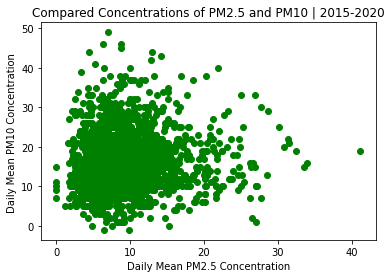

In [ ]:
plt.scatter(DC_PM25_Concentrations['Daily_Mean_PM25_Concentration'][:2000], DC_PM10_Concentrations['Daily Mean PM10 Concentration'][:2000], c="green");
plt.title("Compared Concentrations of PM2.5 and PM10 | 2015-2020");
plt.ylabel("Daily Mean PM10 Concentration ");
plt.xlabel("Daily Mean PM2.5 Concentration");

#### PM2.5 and NO2 concentrations compared from 2015-2020


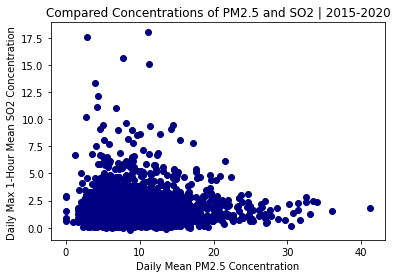

In [ ]:
plt.scatter(DC_PM25_Concentrations['Daily_Mean_PM25_Concentration'][:3000], DC_SO2_Concentrations['Daily Max 1-hour SO2 Concentration'][:3000], c="navy");
plt.title("Compared Concentrations of PM2.5 and SO2 | 2015-2020");
plt.ylabel("Daily Max 1-Hour Mean SO2 Concentration ");
plt.xlabel("Daily Mean PM2.5 Concentration");

#### PM2.5 and NO2 concentrations compared from 2015-2020

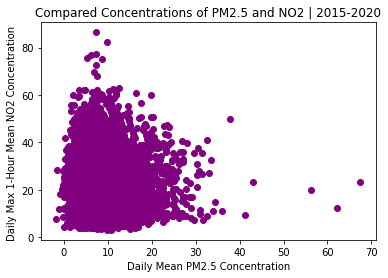

In [ ]:
plt.scatter(DC_PM25_Concentrations['Daily_Mean_PM25_Concentration'][:8000], DC_NO2_Concentrations['Daily Max 1-hour NO2 Concentration'][:8000], c="purple");
plt.title("Compared Concentrations of PM2.5 and NO2 | 2015-2020");
plt.ylabel("Daily Max 1-Hour Mean NO2 Concentration ");
plt.xlabel("Daily Mean PM2.5 Concentration");

#### PM2.5 and SO2 concentrations compared from 2015-2020

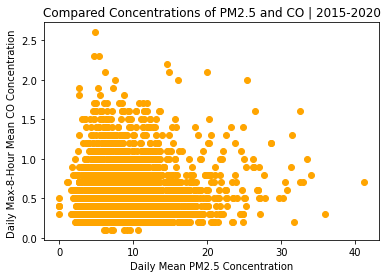

In [ ]:
plt.scatter(DC_PM25_Concentrations['Daily_Mean_PM25_Concentration'][:3000], DC_CO_Concentrations['Daily Max 8-hour CO Concentration'][:3000], c="orange");
plt.title("Compared Concentrations of PM2.5 and CO | 2015-2020");
plt.ylabel("Daily Max-8-Hour Mean CO Concentration ");
plt.xlabel("Daily Mean PM2.5 Concentration");

#### DC PM2.5 Concentrations based on the Air Quality index:

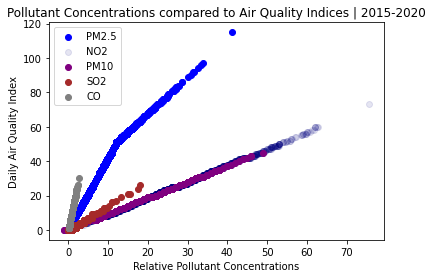

In [ ]:
plt.scatter(DC_PM25_Concentrations['Daily_Mean_PM25_Concentration'][:2000], DC_PM25_Concentrations['DAILY_AQI_VALUE'][:2000], c="blue");
plt.scatter(DC_NO2_Concentrations['Daily Max 1-hour NO2 Concentration'][:3000], DC_NO2_Concentrations['DAILY_AQI_VALUE'][:3000], c='navy' ,alpha=0.1);
plt.scatter(DC_PM10_Concentrations['Daily Mean PM10 Concentration'][:2000], DC_PM10_Concentrations['DAILY_AQI_VALUE'][:2000], c='purple');
plt.scatter(DC_SO2_Concentrations['Daily Max 1-hour SO2 Concentration'][:8000], DC_SO2_Concentrations['DAILY_AQI_VALUE'][:8000], c='brown');
plt.scatter(DC_CO_Concentrations['Daily Max 8-hour CO Concentration'][:3000], DC_CO_Concentrations['DAILY_AQI_VALUE'][:3000], c='gray');
plt.legend(['PM2.5', 'NO2', 'PM10','SO2','CO']);
plt.title("Pollutant Concentrations compared to Air Quality Indices | 2015-2020");
plt.xlabel("Relative Pollutant Concentrations");
plt.ylabel("Daily Air Quality Index");

#### Comparison of pollutant concentrations based on the year(s):


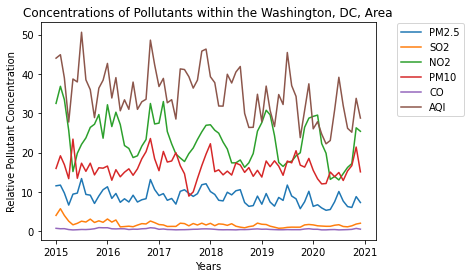

In [ ]:
#Assistance was procured from the following source: https://deallen7.medium.com/managing-date-datetime-and-timestamp-in-python-pandas-cc9d285302ab

# Compile the PM2.5 Concentrations Date-Wise:
DC_PM25_Concentrations['Year'] = pd.DatetimeIndex(DC_PM25_Concentrations['Date']).year
DC_PM25_Concentrations['Month'] = pd.DatetimeIndex(DC_PM25_Concentrations['Date']).month
DC_PM25_Concentrations['DATE'] = pd.to_datetime(DC_PM25_Concentrations[['Year', 'Month']].assign(DAY=1))
DC_PM25_2015to2020 = pd.pivot_table(DC_PM25_Concentrations, values = 'Daily_Mean_PM25_Concentration', index = 'DATE', aggfunc = np.mean) 
plt.plot(DC_PM25_2015to2020)


# Compile the SO2 Concentrations Date-Wise:
DC_SO2_Concentrations['Year'] = pd.DatetimeIndex(DC_SO2_Concentrations['Date']).year
DC_SO2_Concentrations['Month'] = pd.DatetimeIndex(DC_SO2_Concentrations['Date']).month
DC_SO2_Concentrations['DATE'] = pd.to_datetime(DC_SO2_Concentrations[['Year', 'Month']].assign(DAY=1))
DC_SO2_2015to2020 = pd.pivot_table(DC_SO2_Concentrations, values = 'Daily Max 1-hour SO2 Concentration', index = 'DATE', aggfunc = np.mean) 
plt.plot(DC_SO2_2015to2020)

# Compile the NO2 Concentrations Date-Wise:
DC_NO2_Concentrations['Year'] = pd.DatetimeIndex(DC_NO2_Concentrations['Date']).year
DC_NO2_Concentrations['Month'] = pd.DatetimeIndex(DC_NO2_Concentrations['Date']).month
DC_NO2_Concentrations['DATE'] = pd.to_datetime(DC_NO2_Concentrations[['Year', 'Month']].assign(DAY=1))
DC_NO2_2015to2020 = pd.pivot_table(DC_NO2_Concentrations, values = 'Daily Max 1-hour NO2 Concentration', index = 'DATE', aggfunc = np.mean) 
plt.plot(DC_NO2_2015to2020)


# Compile the PM10 Concentrations Date-Wise:
DC_PM10_Concentrations['Year'] = pd.DatetimeIndex(DC_PM10_Concentrations['Date']).year
DC_PM10_Concentrations['Month'] = pd.DatetimeIndex(DC_PM10_Concentrations['Date']).month
DC_PM10_Concentrations['DATE'] = pd.to_datetime(DC_PM10_Concentrations[['Year', 'Month']].assign(DAY=1))
DC_PM10_2015to2020 = pd.pivot_table(DC_PM10_Concentrations, values = 'Daily Mean PM10 Concentration', index = 'DATE', aggfunc = np.mean) 
plt.plot(DC_PM10_2015to2020)


# Compile the CO Concentrations Date-Wise:
DC_CO_Concentrations['Year'] = pd.DatetimeIndex(DC_CO_Concentrations['Date']).year
DC_CO_Concentrations['Month'] = pd.DatetimeIndex(DC_CO_Concentrations['Date']).month
DC_CO_Concentrations['DATE'] = pd.to_datetime(DC_CO_Concentrations[['Year', 'Month']].assign(DAY=1))
DC_CO_2015to2020 = pd.pivot_table(DC_CO_Concentrations, values = 'Daily Max 8-hour CO Concentration', index = 'DATE', aggfunc = np.mean) 
plt.plot(DC_CO_2015to2020);

# #Compile PM2.5 AQI Concentrations Date-Wise: 
DC_PM25_AQI_2015to2020 = pd.pivot_table(DC_PM25_Concentrations, values = 'DAILY_AQI_VALUE', index = 'DATE', aggfunc = np.mean) 
plt.plot(DC_PM25_AQI_2015to2020)

# Modify the plots with essentials:
plt.legend(["PM2.5", "SO2", "NO2", "PM10", "CO", "AQI"], bbox_to_anchor=(1.05, 1.02))
plt.title("Concentrations of Pollutants within the Washington, DC, Area")
plt.xlabel("Years")
plt.ylabel("Relative Pollutant Concentration");

# Correlation and Significance

### PM2.5 vs CO

In [ ]:
#T-Test:
scipy.stats.ttest_ind(DC_PM25_Concentrations['Daily_Mean_PM25_Concentration'][:3000], DC_CO_Concentrations['Daily Max 8-hour CO Concentration'][:3000])

Ttest_indResult(statistic=100.90711434633127, pvalue=0.0)

([<matplotlib.axis.YTick at 0x7f10cccf1350>,
 [Text(0, 0.5, 'PM2.5'), Text(0, 1.5, 'Confounding Pollutants')])

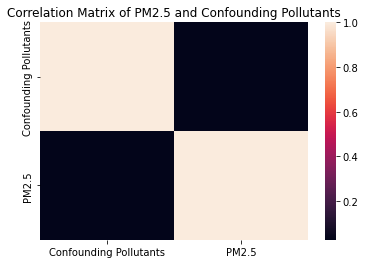

In [ ]:

#Pearson's R Test:
sns.heatmap(np.corrcoef(DC_PM25_Concentrations['Daily_Mean_PM25_Concentration'][:3000], DC_CO_Concentrations['Daily Max 8-hour CO Concentration'][:3000]))
np.corrcoef(DC_PM25_Concentrations['Daily_Mean_PM25_Concentration'][:3000], DC_CO_Concentrations['Daily Max 8-hour CO Concentration'][:3000])
plt.title("Correlation Matrix of PM2.5 and Confounding Pollutants")
plt.xticks([1.5,0.5],["PM2.5", "Confounding Pollutants"])
plt.yticks([1.5,0.5],["PM2.5", "Confounding Pollutants"])


### PM2.5 vs NO2


In [ ]:
#T-Test:
scipy.stats.ttest_ind(DC_PM25_Concentrations['Daily_Mean_PM25_Concentration'][:8000], DC_NO2_Concentrations['Daily Max 1-hour NO2 Concentration'][:8000])

Ttest_indResult(statistic=-103.78904298319357, pvalue=0.0)

array([[1.        , 0.03590951],
       [0.03590951, 1.        ]])

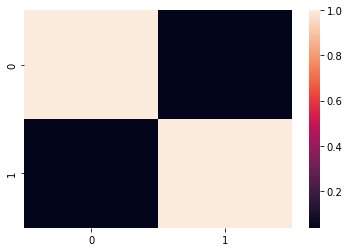

In [ ]:
#Pearson's R Test:
sns.heatmap(np.corrcoef(DC_PM25_Concentrations['Daily_Mean_PM25_Concentration'][:8000], DC_NO2_Concentrations['Daily Max 1-hour NO2 Concentration'][:8000]))
np.corrcoef(DC_PM25_Concentrations['Daily_Mean_PM25_Concentration'][:8000], DC_NO2_Concentrations['Daily Max 1-hour NO2 Concentration'][:8000])

### PM2.5 vs SO2

In [ ]:
#T-Test:
scipy.stats.ttest_ind(DC_PM25_Concentrations['Daily_Mean_PM25_Concentration'][:3000], DC_SO2_Concentrations['Daily Max 1-hour SO2 Concentration'][:3000])

Ttest_indResult(statistic=84.37950081079374, pvalue=0.0)

array([[ 1.        , -0.00517015],
       [-0.00517015,  1.        ]])

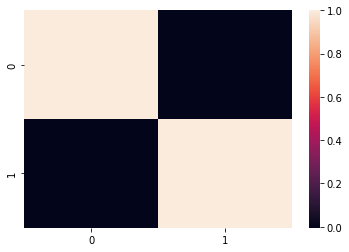

In [ ]:
#Pearson's R Test:
sns.heatmap(np.corrcoef(DC_PM25_Concentrations['Daily_Mean_PM25_Concentration'][:3000], DC_SO2_Concentrations['Daily Max 1-hour SO2 Concentration'][:3000]))

np.corrcoef(DC_PM25_Concentrations['Daily_Mean_PM25_Concentration'][:3000], DC_SO2_Concentrations['Daily Max 1-hour SO2 Concentration'][:3000])

# Linear Regression Analysis 

##### Prepare the data for the regression analysis

In [ ]:
DC_PM25_2015to2020 = DC_PM25_2015to2020.reset_index()
DC_PM25_2015to2020

,DATE,Daily_Mean_PM25_Concentration
0,2015-01-01,11.548148
1,2015-02-01,11.724638
2,2015-03-01,9.717073
3,2015-04-01,6.647436
4,2015-05-01,9.430769
...,...,...
67,2020-08-01,7.665244
68,2020-09-01,6.267742
69,2020-10-01,6.045806
70,2020-11-01,8.801250


In [ ]:
PM25_Analyzer = pd.DataFrame(DC_PM10_2015to2020['Daily Mean PM10 Concentration'][:72]).reset_index()
PM25_Analyzer2 = pd.DataFrame(DC_PM25_2015to2020['Daily_Mean_PM25_Concentration'][:72]).reset_index()
PM25_Analyzer7 = pd.DataFrame(DC_PM25_2015to2020['DATE'][:72]).reset_index()
PM25_Analyzer3 = pd.DataFrame(DC_SO2_2015to2020['Daily Max 1-hour SO2 Concentration'][:72]).reset_index()
PM25_Analyzer4 =  pd.DataFrame(DC_NO2_2015to2020['Daily Max 1-hour NO2 Concentration'][:72]).reset_index()
PM25_Analyzer5 = pd.DataFrame(DC_CO_2015to2020['Daily Max 8-hour CO Concentration'][:72]).reset_index()
PM25_Analyzer6 = pd.DataFrame(DC_PM25_AQI_2015to2020['DAILY_AQI_VALUE'][:72]).reset_index()
PM25_Analyzer['Daily Max 1-hour SO2 Concentration']=  PM25_Analyzer3['Daily Max 1-hour SO2 Concentration']
PM25_Analyzer['Daily Max 1-hour NO2 Concentration'] =   PM25_Analyzer4['Daily Max 1-hour NO2 Concentration']
PM25_Analyzer['Daily Max 8-hour CO Concentration'] = PM25_Analyzer5['Daily Max 8-hour CO Concentration']
PM25_Analyzer['Daily_Mean_PM25_Concentration'] = PM25_Analyzer2['Daily_Mean_PM25_Concentration']
PM25_Analyzer['DAILY_AQI_VALUE'] = PM25_Analyzer6['DAILY_AQI_VALUE']
PM25_Analyzer['DATE'] = PM25_Analyzer7['DATE']
PM25_Analyzer = PM25_Analyzer

In [ ]:
PM25_Analyzer

,DATE,Daily Mean PM10 Concentration,Daily Max 1-hour SO2 Concentration,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour CO Concentration,Daily_Mean_PM25_Concentration,DAILY_AQI_VALUE
0,2015-01-01,15.967742,4.025806,32.500000,0.740323,11.548148,44.000000
1,2015-02-01,19.178571,5.732000,36.846429,0.630769,11.724638,44.884058
2,2015-03-01,16.935484,4.019355,33.450000,0.651613,9.717073,39.000000
3,2015-04-01,13.366667,2.556667,25.636667,0.423333,6.647436,27.756410
4,2015-05-01,23.419355,1.629032,15.172581,0.333871,9.430769,38.705128
...,...,...,...,...,...,...,...
67,2020-08-01,12.903226,1.206452,14.652703,0.375806,7.665244,31.920732
68,2020-09-01,15.333333,1.123333,16.229054,0.415000,6.267742,26.167742
69,2020-10-01,16.677419,1.370968,17.190909,0.474194,6.045806,25.174194
70,2020-11-01,21.400000,1.823333,26.295270,0.716667,8.801250,33.787500


#### Determine if model can predict PM2.5, NO2, and CO fluctuations respecively

In [ ]:
# Create binary month variables for OLS analysis:
PM25_Analyzer= PM25_Analyzer.set_index('DATE')
binarized_months = pd.get_dummies(PM25_Analyzer.index.month).rename(columns={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
binarized_months.head()

#Clean the newly modified PM2.5 Analyzer: 
PM25_Analyzer = PM25_Analyzer.reset_index()
PM25_Analyzer = pd.concat([PM25_Analyzer, binarized_months], axis=1)

# Construct training and testing datasets and split them based on time-period: 
PM25_Training_Set = PM25_Analyzer.loc[PM25_Analyzer['DATE'] < '01/01/2021']
PM25_Testing_Set = PM25_Analyzer.loc[PM25_Analyzer['DATE'] >= '01/01/2021']

# Add primary features: 
values = ['Daily Max 1-hour NO2 Concentration', 'Daily Max 1-hour SO2 Concentration','Daily Max 8-hour CO Concentration','Jan','Feb','Mar','Apr', 'May', 'Jul', 'Aug', 'Nov', 'Dec']

# Construct a model for Ordinary Least Squares:
# Source: https://datatofish.com/statsmodels-linear-regression/
def OLSConstructor(data,target, feature):
    import statsmodels.api as sa
    
    # Construct the X and Y variables
    target_y = data[target]
    feature_x = data[feature]
    
    # Develop the constant
    feature_x = sa.add_constant(feature_x)
    
    # Ordinary Least Squares Model
    the_model = sa.OLS(target_y,feature_x).fit()
    
    return the_model,feature_x,target_y

# Construct the machine learning model based on OLS: 
THE_MODEL, X_PM25, Y_PM25 = OLSConstructor(PM25_Training_Set, 'Daily_Mean_PM25_Concentration', values)
print(THE_MODEL.summary())

# Make Predictions:
PM25_Predictions = THE_MODEL.predict(X_PM25)
PM25_Training_Set['Predictions_PM25'] = PM25_Predictions

                                  OLS Regression Results                                 
Dep. Variable:     Daily_Mean_PM25_Concentration   R-squared:                       0.540
Model:                                       OLS   Adj. R-squared:                  0.447
Method:                            Least Squares   F-statistic:                     5.777
Date:                           Mon, 29 Nov 2021   Prob (F-statistic):           1.77e-06
Time:                                   03:43:27   Log-Likelihood:                -117.45
No. Observations:                             72   AIC:                             260.9
Df Residuals:                                 59   BIC:                             290.5
Df Model:                                     12                                         
Covariance Type:                       nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.97

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mean Absolute Error: 1.0537715273140895
Mean Squared Error: 1.5289282645216475
Root Mean Squared Error: 1.2364983884023657


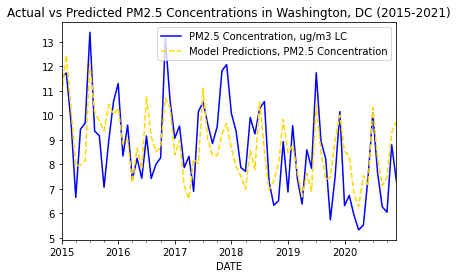

In [ ]:
#Plot the figure of the Actual vs. Predicted: 
PM25_predict_fig, PM25_predict_ax = plt.subplots()
PM25_Training_Set.plot(x='DATE', y='Daily_Mean_PM25_Concentration', ax=PM25_predict_ax, c="blue")
PM25_Training_Set.plot(x='DATE', y='Predictions_PM25', linestyle='--', ax=PM25_predict_ax, c="gold")
PM25_predict_ax.legend(['PM2.5 Concentration, ug/m3 LC', 'Model Predictions, PM2.5 Concentration']);
plt.title("Actual vs Predicted PM2.5 Concentrations in Washington, DC (2015-2021)")

# Measure the accuracy of the model: 
print('Mean Absolute Error:', metrics.mean_absolute_error(PM25_Training_Set['Daily_Mean_PM25_Concentration'], PM25_Predictions))
print('Mean Squared Error:', metrics.mean_squared_error(PM25_Training_Set['Daily_Mean_PM25_Concentration'], PM25_Predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(PM25_Training_Set['Daily_Mean_PM25_Concentration'], PM25_Predictions)))

#### Additional Sources

https://stackabuse.com/linear-regression-in-python-with-scikit-learn/

https://www.sagepub.com/sites/default/files/upm-binaries/33663_Chapter4.pdf